<a href="https://colab.research.google.com/github/ekowturkson/MS-Group-Project-22/blob/master/Copy_of_finalWork_Big_Data_Query_%26_Analysis_by_Apache_Hive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Update system packages
!sudo apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,871 kB]
Hit:13 http://ppa.la

In [ ]:
#install Java
!sudo apt install default-jdk

In [ ]:
# Download Apache Spark and extract
!wget https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xvf spark-3.0.3-bin-hadoop2.7.tgz

In [ ]:
#Install pyspark
!pip install -q findspark
!pip install pyspark

In [ ]:
#setting the environment path 
import os
from os.path import abspath
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
# warehouse_location points to the default location for managed databases and tables
warehouse_location = abspath('spark-warehouse')

In [ ]:
#Running a local SparkSession
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").config("spark.sql.warehouse.dir", warehouse_location).enableHiveSupport().getOrCreate()

In [ ]:
#Hive
from pyspark.sql import Row
from pyspark.sql import HiveContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [ ]:
#libraries used
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functools import reduce
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler,IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from sklearn.metrics import classification_report,confusion_matrix
import re
from pyspark.ml.stat import Correlation,ChiSquareTest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator

In [ ]:
# Creating a list of the schema in the format column_name, data_type
labels = [
           ('srcip', StringType()),('sport',IntegerType()),('dstip',StringType()),('dsport',IntegerType()),
           ('proto_trans', StringType()),('state', StringType()),('dur',DoubleType()),('sbytes',IntegerType()),
          ('dbytes',IntegerType()),('sttl', IntegerType()),('dttl', IntegerType()),('sloss',IntegerType()),
           ('dloss',IntegerType()),('proto',StringType()),('Sload',DoubleType()),('Dload',DoubleType()),
           ('Spkts',IntegerType()),('Dpkts',IntegerType()),('swin',IntegerType()),('dwin', IntegerType()),
           ('stcpb',IntegerType()),('dtcpb',IntegerType()),('smeansz',IntegerType()),('dmeansz',IntegerType()),
           ('trans_depth',IntegerType()),('res_bdy_len',IntegerType()),('Sjit',DoubleType()),('Djit',DoubleType()),
           ('Stime',IntegerType()),('Ltime',IntegerType()),('Sintpkt',DoubleType()),('Dintpkt',DoubleType()),
           ('tcprtt',DoubleType()),('synack',DoubleType()),('ackdat',DoubleType()),('is_sm_ips_ports',IntegerType()),
          ('ct_state_ttl',IntegerType()),('ct_flw_http_mthd',IntegerType()),('is_ftp_login',IntegerType()),
          ('ct_ftp_cmd',IntegerType()),('ct_srv_src',IntegerType()),('ct_srv_dst',IntegerType()),
          ('ct_dst_ltm',IntegerType()),('ct_src_ ltm',IntegerType()),('ct_src_dport_ltm',IntegerType()),
          ('ct_dst_sport_ltm',IntegerType()),('ct_dst_src_ltm',IntegerType()),('attack_cat',StringType()),
          ('Label',DoubleType())]


In [ ]:
# Creating the schema that will be passed when reading the csv
schema = StructType([StructField (x[0], x[1], True) for x in labels])


In [ ]:
#Load data with spark
df = spark.read.csv("UNSW-NB15.csv",sep=',', header=None, schema=schema)

In [ ]:
#checking schema of dataframe
df.printSchema()

In [ ]:
#checking number of rows in dataframe
df.count()

1012561

In [ ]:
df.count(),df.distinct().count()

(804688, 597420)

In [ ]:
data = df.dropDuplicates()

In [ ]:
data.count()

597420

In [ ]:
#get dimension of data
(data.count() , len(data.columns))

(597420, 49)

In [ ]:
#check null value count in your dataset
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+-----+-----+-----+------+-----------+-----+---+------+------+----+----+-----+-----+-----+-----+-----+-----+-----+----+----+------+------+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto_trans|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|proto|Sload|Dload|Spkts|Dpkts|swin|dwin| stcpb| dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----------+-----+---+------+------+----+----+-----+-----+-----+-----+-----+-----+-----+----+----+------+------+-------+-------+--------

In [ ]:
#Replace all null values which represents normal records with 'Normal' in the attack_cat column 
data = data.na.fill(value='Normal',subset=["attack_cat"])

In [ ]:
#check null value count in your dataset
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+-----+-----+-----+------+-----------+-----+---+------+------+----+----+-----+-----+-----+-----+-----+-----+-----+----+----+------+------+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto_trans|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|proto|Sload|Dload|Spkts|Dpkts|swin|dwin| stcpb| dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----------+-----+---+------+------+----+----+-----+-----+-----+-----+-----+-----+-----+----+----+------+------+-------+-------+--------

In [ ]:
data.select('proto').distinct().show()

+--------+
|   proto|
+--------+
|     ftp|
|ftp-data|
|     dns|
|    smtp|
|    http|
|  radius|
|     ssl|
|Not Used|
|     irc|
|    dhcp|
|    snmp|
|    pop3|
|     ssh|
+--------+



In [ ]:
#Replace all dashes(-) which represents services not much used with 'Not Used' in the proto column
data = data.withColumn('proto', regexp_replace('proto','-','Not Used'))

In [ ]:
data.select('proto').distinct().show()

+---------------+
|          proto|
+---------------+
|            ftp|
|            dns|
|           smtp|
|           http|
|         radius|
|            ssl|
|ftpNot Useddata|
|       Not Used|
|            irc|
|           dhcp|
|           snmp|
|           pop3|
|            ssh|
+---------------+



In [ ]:
#Replace all dashes(-) which represents services not much used with 'Not Used' in the proto column
data = data.withColumn('proto', regexp_replace('proto','ftpNot Useddata','ftp-data'))

In [ ]:
data.select('proto').distinct().show()

+--------+
|   proto|
+--------+
|     ftp|
|ftp-data|
|     dns|
|    smtp|
|    http|
|  radius|
|     ssl|
|Not Used|
|     irc|
|    dhcp|
|    snmp|
|    pop3|
|     ssh|
+--------+



In [ ]:
#Using DataFrames to create temporary views within a SparkSession.
data.createOrReplaceTempView("logdata")

In [ ]:
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |  logdata|       true|
+--------+---------+-----------+



In [ ]:
spark.sql("SELECT from_unixtime(unix_timestamp(),'yyyy-MM-dd-HH:mm:ss') as date FROM logdata;").show()

In [ ]:
spark.sql("select * from logdata").show()

In [ ]:
spark.sql('select distinct(nvl(trim(attack_cat),"Normal")) as attack_categories, \
           count(*) as total \
           from logdata \
           group by attack_cat \
           order by total desc').show()

In [ ]:
#Retrieving a count of the number of rows in the logadata view
spark.sql('select count(*) as number_of_rows_count from logdata').show()

+--------------------+
|number_of_rows_count|
+--------------------+
|              597420|
+--------------------+



In [ ]:
spark.sql("select distinct(attack_cat) \
                  from logdata \
                  where attack_cat != 'Normal'").show()

+---------------+
|     attack_cat|
+---------------+
|          Worms|
|       Analysis|
|     Shellcode |
|            DoS|
|Reconnaissance |
|       Backdoor|
|       Fuzzers |
|       Exploits|
|        Generic|
+---------------+



In [ ]:
# 1 Query  to find the count of attacked and normal record
attacked_and_normal_records = spark.sql("select count(Label) as number_of_records , \
                     CASE \
                        WHEN label = 0 THEN 'NORMAL RECORDS'\
	                      ELSE 'ATTACKED RECORDS'\
                     END AS attack_or_normal_records\
                     from logdata\
                     group by Label")

attacked_and_normal_records.show()

+-----------------+------------------------+
|number_of_records|attack_or_normal_records|
+-----------------+------------------------+
|            46565|        ATTACKED RECORDS|
|           550855|          NORMAL RECORDS|
+-----------------+------------------------+



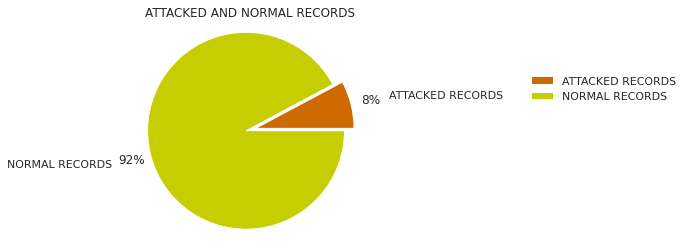

In [ ]:
##visulaization of attacked and normal records
attacked_normal = attacked_and_normal_records.toPandas()

color_palette_list = ['#cd6a00','#c6cd00','#63D1F4','#0EBFE9','#09e677','#cd0a00',
                      '#C1F0F6','#0018cd','#0099CC','#9300cd','#cd0071']

fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
#plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12

explode=(0.1,0)
sns.set(style="darkgrid")
ax.pie(attacked_normal['number_of_records'], explode=explode, labels=attacked_normal['attack_or_normal_records'],  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("ATTACKED AND NORMAL RECORDS")
ax.legend(frameon=False, bbox_to_anchor=(1.8,0.8))

In [ ]:
# 2 Query to find distinct attack categories and the count for each category
attack_categories = spark.sql('select distinct(nvl(trim(attack_cat),"Normal")) as attack_categories, \
           count(*) as total \
           from logdata \
           group by attack_cat \
           order by total desc')

attack_categories.show()

+-----------------+------+
|attack_categories| total|
+-----------------+------+
|           Normal|550855|
|         Exploits| 13006|
|          Generic| 12066|
|          Fuzzers|  9805|
|   Reconnaissance|  6390|
|              DoS|  2593|
|         Backdoor|   972|
|         Analysis|   934|
|        Shellcode|   718|
|            Worms|    81|
+-----------------+------+



In [ ]:
cat_data  = attack_categories.toPandas()

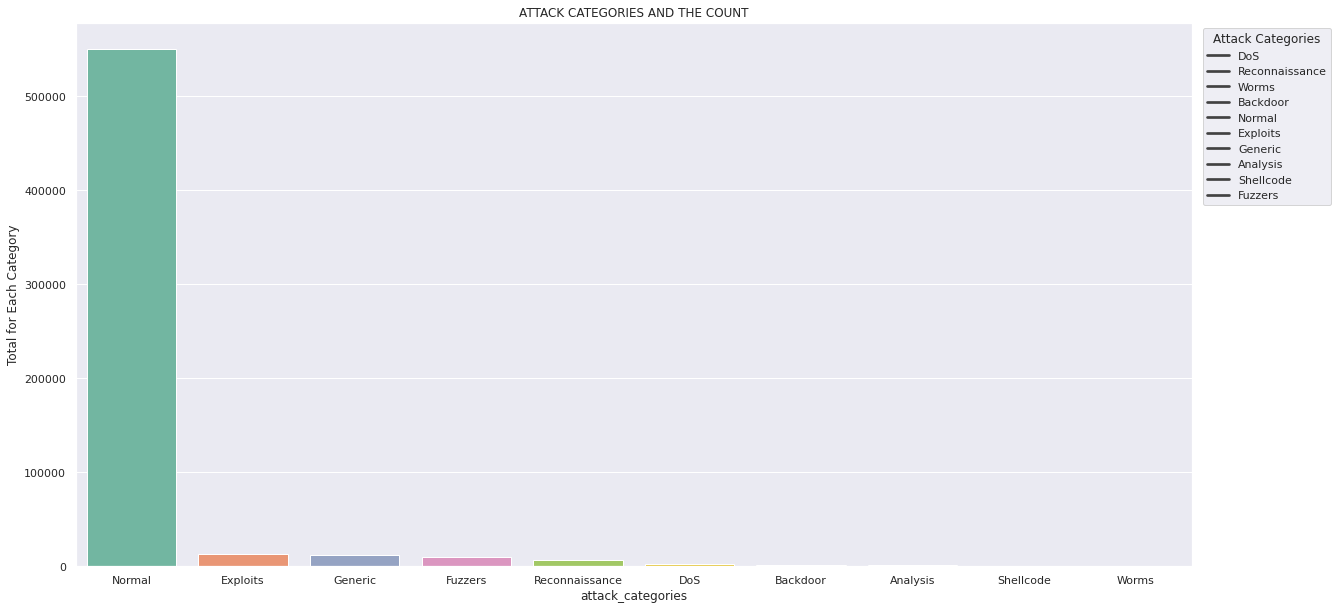

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.set(style="darkgrid")
ax = sns.barplot(data=cat_data, x='attack_categories',y='total', palette= 'Set2')
ax.set_ylabel("Total for Each Category")
ax.set_title("ATTACK CATEGORIES AND THE COUNT")
ax.legend(labels = ["DoS","Reconnaissance","Worms","Backdoor","Normal","Exploits","Generic","Analysis","Shellcode","Fuzzers"], title="Attack Categories",bbox_to_anchor= (1.13, 1) )
plt.show()

In [ ]:
# 3 Query to find the most used protocol and the count
proto_attack = spark.sql("select proto as most_used, \
                                 count(*) as number_of_records \
                                 from logdata \
                                  where attack_cat != 'Normal' \
                                 group by proto order \
                                 by number_of_records desc")
proto_attack.show()

+---------+-----------------+
|most_used|number_of_records|
+---------+-----------------+
|        -|             2125|
|     http|              795|
|      dns|              264|
|     smtp|              192|
|     pop3|               66|
|      ftp|               60|
| ftp-data|               36|
|     dhcp|                7|
|     snmp|                5|
|      ssl|                5|
|      irc|                1|
|      ssh|                1|
+---------+-----------------+



In [ ]:
proto_attack = proto_attack.toPandas()

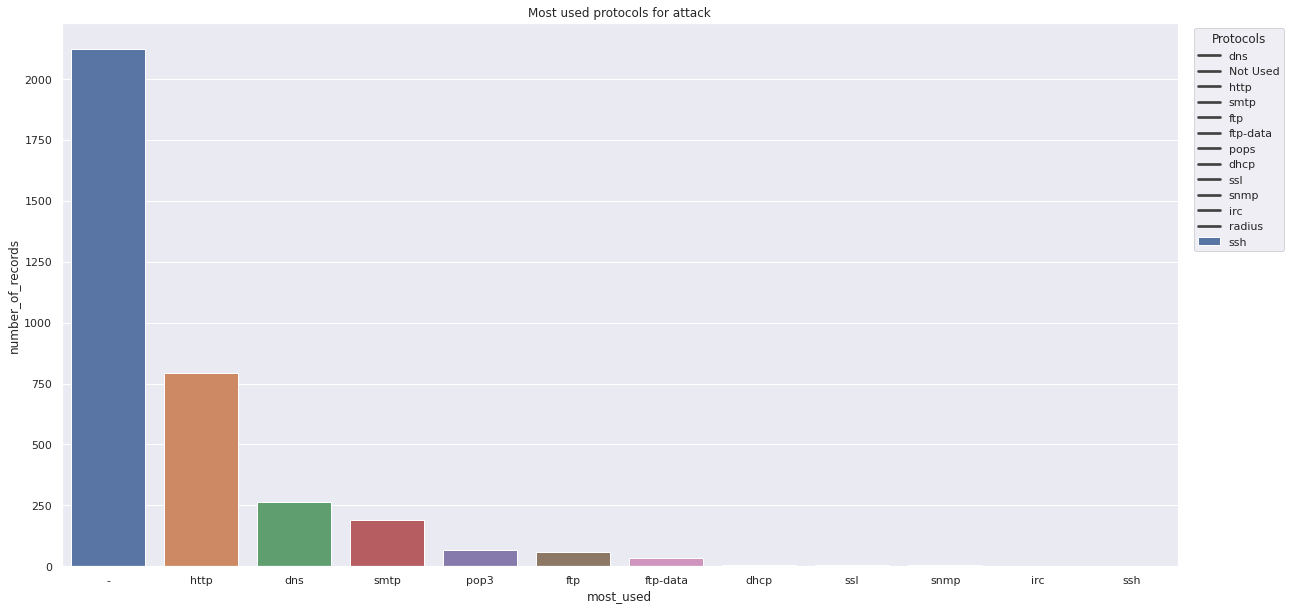

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x='most_used',y='number_of_records',data=proto_attack, palette='deep')
plt.title("Most used protocols for attack")
plt.legend(labels=['dns','Not Used','http','smtp','ftp','ftp-data', 'pops', 'dhcp','ssl','snmp','irc','radius','ssh'],bbox_to_anchor= (1.10, 1), title= 'Protocols')

In [ ]:
# 4 Query to find the number of normal records and the state used
state_normal = spark.sql("select state as state_normal, \
                                 count(*) as number_of_records \
                                 from logdata \
                                  where attack_cat = 'Normal' \
                                 group by state order \
                                 by number_of_records desc")
state_normal.show()

+------------+-----------------+
|state_normal|number_of_records|
+------------+-----------------+
|         FIN|           384467|
|         CON|           150335|
|         INT|            13771|
|         REQ|             1919|
|         RST|              286|
|         ECO|               35|
|         PAR|               17|
|         ACC|                5|
|          no|                4|
|         URN|                4|
|         ECR|                3|
|         MAS|                3|
|         TST|                3|
|         TXD|                3|
+------------+-----------------+



In [ ]:
state_normal = state_normal.toPandas()

Text(0.5, 1.0, 'number of normal records and the state used')

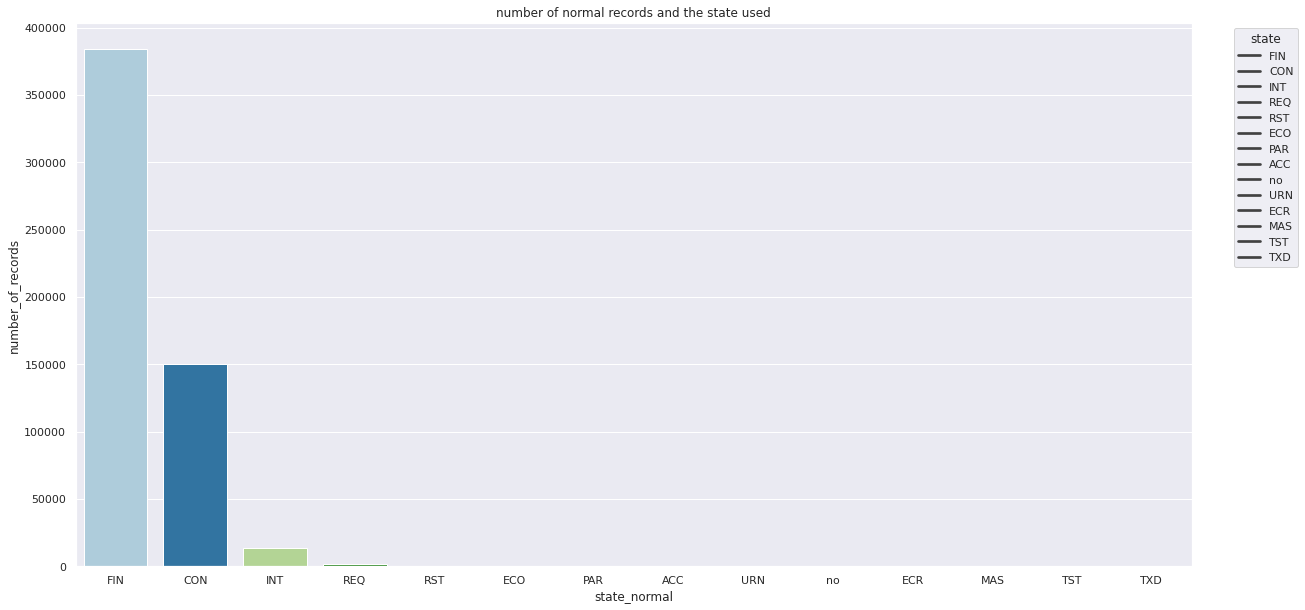

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x='state_normal',y='number_of_records',data=state_normal, palette='Paired')
plt.legend(labels=['FIN','CON','INT','REQ','RST','ECO','PAR','ACC','no','URN','ECR','MAS','TST','TXD'],bbox_to_anchor= (1.10, 1), title='state')
plt.title("number of normal records and the state used")

In [ ]:
# 5 Query to find the most used state for attack and the count
state_attack = spark.sql("select state as most_used, \
                                 count(*) as number_of_records \
                                 from logdata \
                                 where attack_cat != 'Normal' \
                                 group by state \
                                 order by number_of_records desc")
state_attack.show()

+---------+-----------------+
|most_used|number_of_records|
+---------+-----------------+
|      FIN|            25425|
|      INT|            20577|
|      CON|              415|
|      REQ|              140|
|      RST|                7|
|      ACC|                1|
+---------+-----------------+



In [ ]:
state_attack = state_attack.toPandas()

Text(0.5, 1.0, 'Most used state for attack')

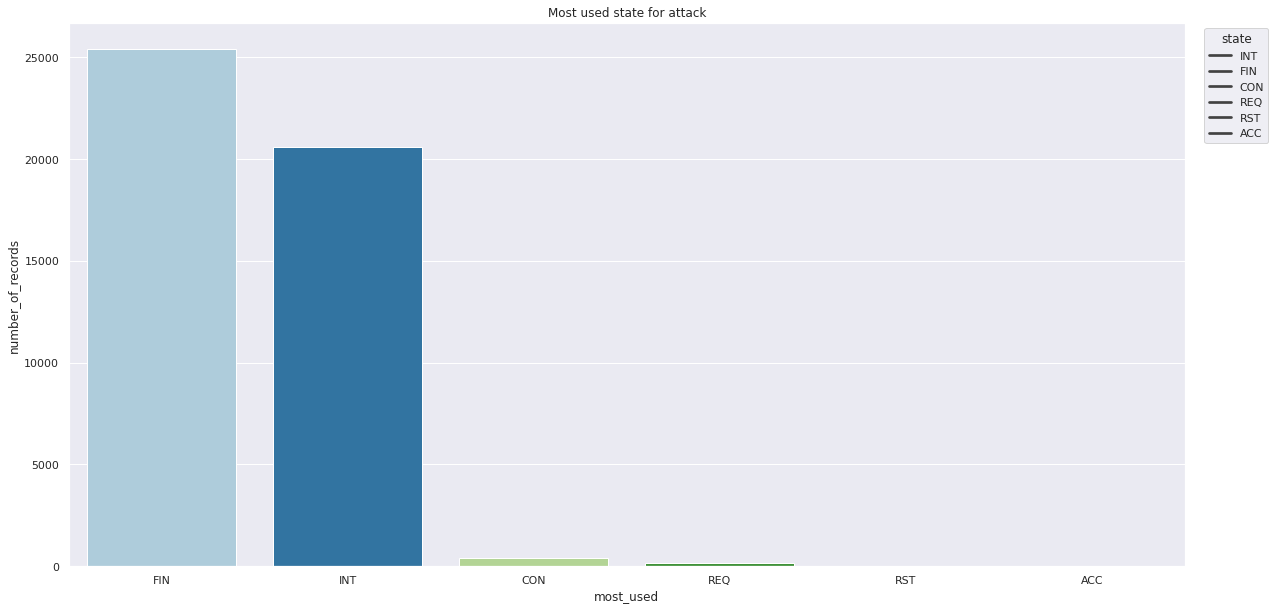

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x='most_used',y='number_of_records',data=state_attack, palette='Paired')
plt.legend(labels=['INT','FIN','CON','REQ','RST','ACC'],bbox_to_anchor= (1.08, 1),title='state')
plt.title("Most used state for attack")

In [ ]:
# 6 Most used protocol for each attack category
proto_record = spark.sql("select attack_cat, \
                                 proto, \
                                 count(*) as total \
                                 from logdata \
                                 where attack_cat != 'Normal' \
                                 group by attack_cat, proto \
                                 order by attack_cat,proto")
proto_record.show()

+----------+--------+-----+
|attack_cat|   proto|total|
+----------+--------+-----+
|  Analysis|Not Used|  716|
|  Analysis|    http|  215|
|  Analysis|    smtp|    3|
|  Backdoor|Not Used|  919|
|  Backdoor|     ftp|    3|
|  Backdoor|    http|   44|
|  Backdoor|     irc|    6|
|       DoS|Not Used| 1369|
|       DoS|    dhcp|   19|
|       DoS|     dns|   61|
|       DoS|     ftp|   35|
|       DoS|ftp-data|    8|
|       DoS|    http|  839|
|       DoS|     irc|    4|
|       DoS|    pop3|   44|
|       DoS|    smtp|  199|
|       DoS|    snmp|   10|
|       DoS|     ssl|    5|
|  Exploits|Not Used| 3471|
|  Exploits|    dhcp|   21|
+----------+--------+-----+
only showing top 20 rows



In [ ]:
proto_record = proto_record.toPandas()


Text(0.5, 1.0, 'Most used protocol for each attack category')

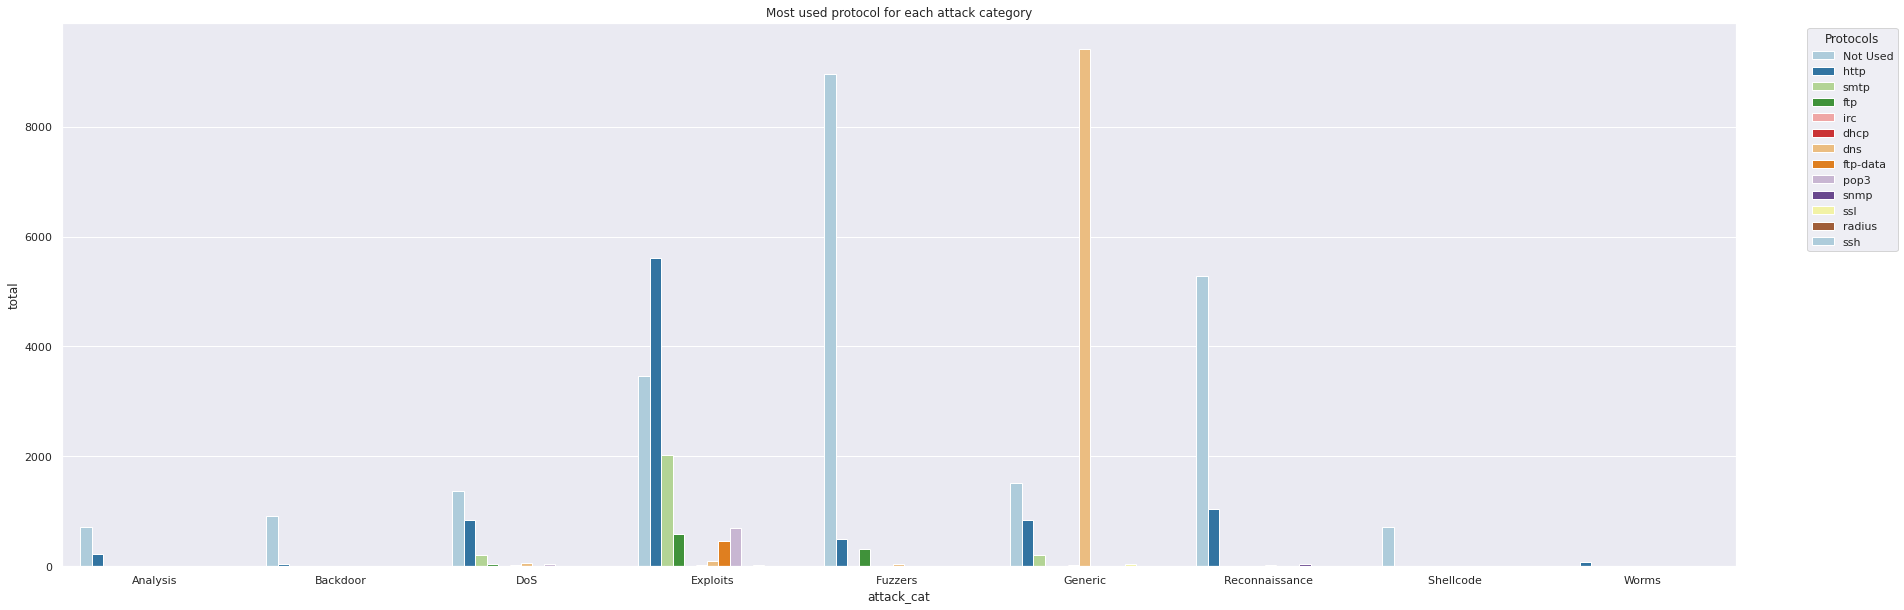

In [ ]:
##visualization
fig, ax = plt.subplots(figsize = (30,10))
sns.set(style="darkgrid")
sns.barplot(x='attack_cat', y = 'total', hue= 'proto',  
            data = proto_record, palette='Paired',ax=ax)
ax.legend(bbox_to_anchor= (1.10, 1),title = 'Protocols')
plt.title("Most used protocol for each attack category")
#plt.ylim(0,250000)

In [ ]:
#7 Most used state for each attack category attack
attack_state = spark.sql("select attack_cat, \
                                 state, \
                                 count(*) as total \
                                 from logdata \
                                 where attack_cat != 'Normal' \
                                 group by attack_cat,state \
                                 order by attack_cat,state")
attack_state.show()

+----------+-----+-----+
|attack_cat|state|total|
+----------+-----+-----+
|  Analysis|  CON|    5|
|  Analysis|  FIN|  218|
|  Analysis|  INT|  707|
|  Analysis|  REQ|    4|
|  Backdoor|  CON|   31|
|  Backdoor|  FIN|  155|
|  Backdoor|  INT|  771|
|  Backdoor|  REQ|   15|
|       DoS|  CON|  103|
|       DoS|  FIN| 1534|
|       DoS|  INT|  939|
|       DoS|  REQ|   17|
|  Exploits|  ACC|    1|
|  Exploits|  CON|  189|
|  Exploits|  FIN|11781|
|  Exploits|  INT| 1014|
|  Exploits|  REQ|   17|
|  Exploits|  RST|    4|
|  Fuzzers |  CON|   17|
|  Fuzzers |  FIN| 6546|
+----------+-----+-----+
only showing top 20 rows



In [ ]:
attack_state = attack_state.toPandas()

Text(0.5, 1.0, 'Most used state for each attack category')

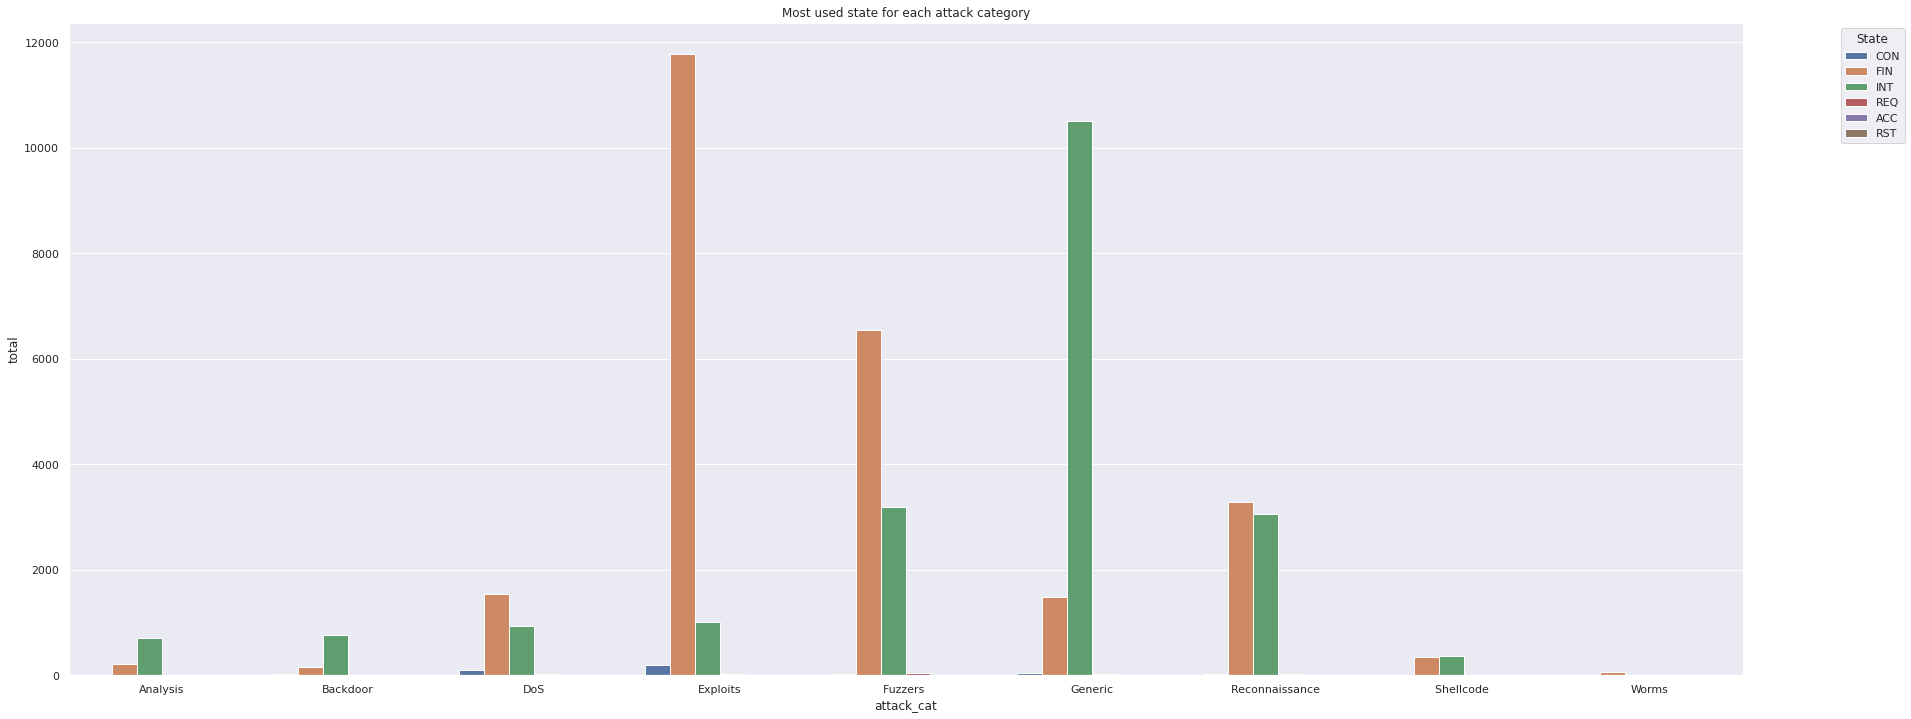

In [ ]:
#visualization
fig, ax = plt.subplots(figsize = (30,12))
sns.set(style="darkgrid")
sns.barplot(x='attack_cat', y = 'total', hue= 'state', data = attack_state, palette='deep',ax=ax)
ax.legend(bbox_to_anchor= (1.10, 1),title = 'State')
sns.set_style('darkgrid')
#plt.ylim(0,250000)
plt.title("Most used state for each attack category")

In [ ]:
# 8 Query to dates on which records were recorded and the count 
distinct_date = spark.sql("select distinct(to_date(from_unixtime(Stime))) as distinct_dates, \
                                  count(*) as total \
                                  from logdata \
                                  group by distinct_dates")
distinct_date.show()

+--------------+-----+
|distinct_dates|total|
+--------------+-----+
|    2015-01-23|20053|
|    2015-01-22| 8916|
|    2015-02-18|46704|
+--------------+-----+



In [ ]:
distinct_date = distinct_date.toPandas()

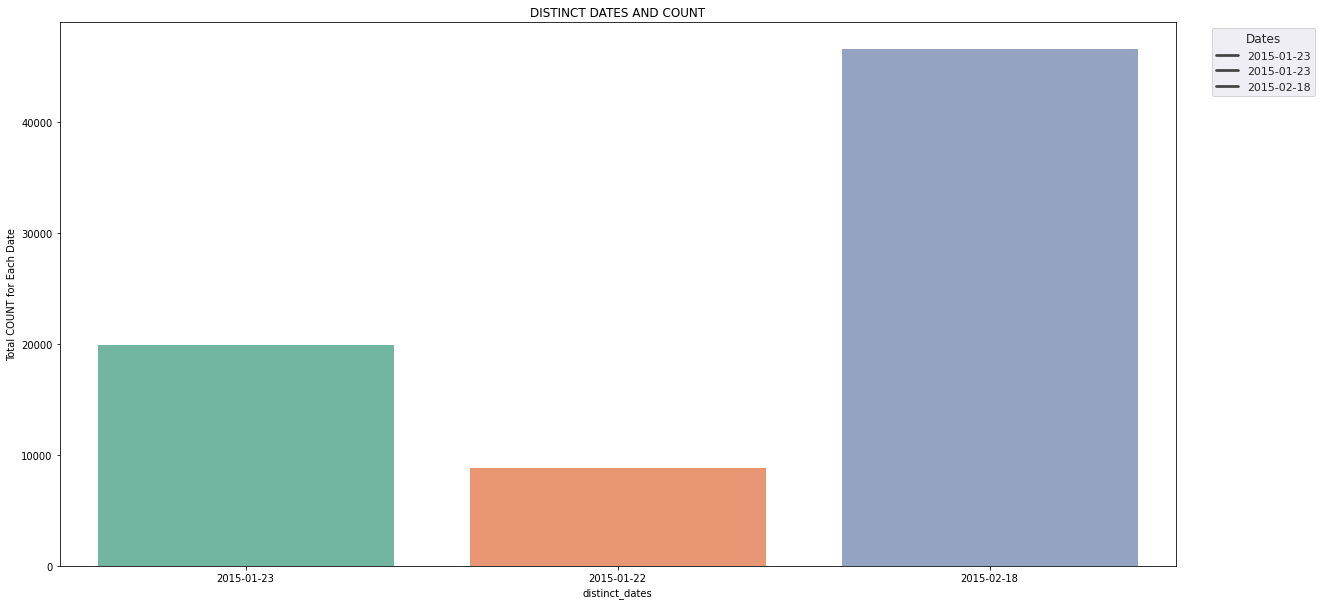

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.set(style="darkgrid")
ax = sns.barplot(data=distinct_date, x='distinct_dates',y='total', palette= 'Set2')
ax.set_ylabel("Total COUNT for Each Date")
ax.set_title("DISTINCT DATES AND COUNT")
ax.legend(labels = ["2015-01-23","2015-01-23","2015-02-18"], title="Dates",bbox_to_anchor= (1.13, 1) )
plt.show()

In [ ]:
# 9 Query to dates on which records were recorded and the count 
dur = spark.sql("select distinct(trim(attack_cat)) as attack_category, \
                  round(avg(dur),3) as average_duration\
                  from logdata \
                  where attack_cat !='Normal' \
                  group by attack_category \
                  order by average_duration desc ")
dur.show()

+---------------+----------------+
|attack_category|average_duration|
+---------------+----------------+
|          Worms|           1.417|
|        Fuzzers|           1.237|
|       Exploits|           1.128|
|            DoS|           0.755|
| Reconnaissance|           0.439|
|       Backdoor|           0.377|
|      Shellcode|           0.349|
|        Generic|           0.294|
|       Analysis|           0.074|
+---------------+----------------+



In [ ]:
dur = dur.toPandas()

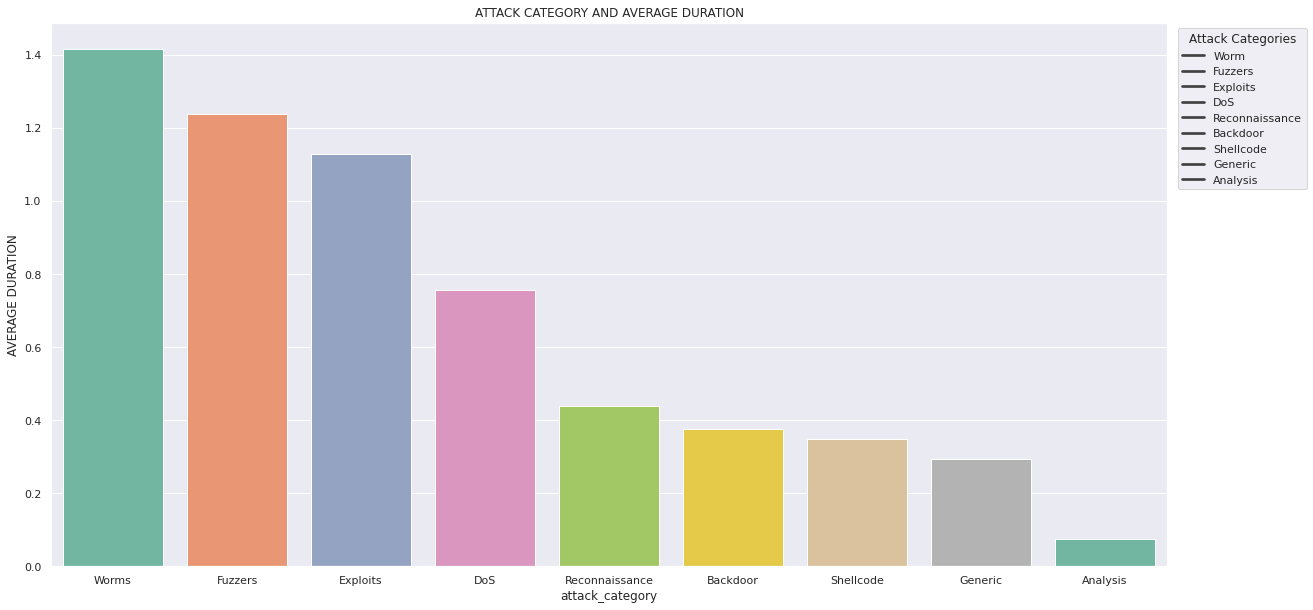

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.set(style="darkgrid")
ax = sns.barplot(data=dur, x='attack_category',y='average_duration', palette= 'Set2')
ax.set_ylabel("AVERAGE DURATION")
ax.set_title("ATTACK CATEGORY AND AVERAGE DURATION")
ax.legend(labels = ["Worm", "Fuzzers","Exploits","DoS","Reconnaissance",'Backdoor','Shellcode','Generic','Analysis'], title="Attack Categories",bbox_to_anchor= (1.13, 1) )
plt.show()

In [ ]:
# 8 Query to dates on which records were recorded and the count 
spark.sql("select distinct(trim(attack_cat)), avg(dur) from logdata group by attack_cat").show()

+----------------+-------------------+
|trim(attack_cat)|           avg(dur)|
+----------------+-------------------+
|        Backdoor| 0.3772970049265492|
|  Reconnaissance| 0.4393908511518705|
|       Shellcode| 0.3492904013461846|
|             DoS| 0.7548358837907302|
|          Normal|  0.691109531187542|
|         Generic|0.29371953393091144|
|        Analysis|0.07386638685959088|
|           Worms| 1.4173421433333557|
|        Exploits| 1.1284996136765375|
|         Fuzzers|  1.237379753755412|
+----------------+-------------------+



In [ ]:
# 3. Advanced Analytics using PySpark
# 3.1 Analyze and Interpret Big Data
import pyspark.sql.functions as f

In [ ]:
#Descriptive
df.describe().show()

+-------+-----------+------------------+-----------+------------------+-----------+------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+-----------------+-------------------+------------------+------------------+-----------------+--------------------+-------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+----------+-------------------+
|summary|      srcip|             sport|      dstip|            dsport|proto_trans| state|           

In [ ]:
#Summary
df.summary().show()

+-------+-----------+------------------+-----------+------------------+-----------+------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+-----------------+-------------------+------------------+------------------+-----------------+--------------------+-------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+----------+-------------------+
|summary|      srcip|             sport|      dstip|            dsport|proto_trans| state|           

In [ ]:
#Data preprocessing
# check for duplicated rows
df.groupby(df.columns).count().filter('count > 1').show()

In [ ]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+-----+-----+------+-----------+-----+---+------+------+----+----+-----+-----+-----+-----+-----+-----+-----+----+----+------+------+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto_trans|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|proto|Sload|Dload|Spkts|Dpkts|swin|dwin| stcpb| dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----------+-----+---+------+------+----+----+-----+-----+-----+-----+-----+-----+-----+----+----+------+------+-------+-------+--------

In [ ]:
#Data preprocessing
#checking null and missing values
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+-----+-----+-----+------+-----------+-----+---+------+------+----+----+-----+-----+-----+-----+-----+-----+-----+----+----+------+------+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto_trans|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|proto|Sload|Dload|Spkts|Dpkts|swin|dwin| stcpb| dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----------+-----+---+------+------+----+----+-----+-----+-----+-----+-----+-----+-----+----+----+------+------+-------+-------+--------

In [ ]:
#Data preprocessing
# check for total and distinct rows
print(df.count(), df.distinct().count())
# Remove duplicated rows
df= df.dropDuplicates()

1012561 743923


In [ ]:
#check data count
df.count()

2059115

In [ ]:
#Replace all null values which represents normal records with 'Normal' in the attack_cat column 
df = df.na.fill(value='Normal',subset=["attack_cat"])

In [ ]:
#fill null values with 0
df = df.fillna(0)

In [ ]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+-----+-----+------+-----------+-----+---+------+------+----+----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto_trans|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|proto|Sload|Dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----------+-----+---+------+------+----+----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+--

In [ ]:
#Replace all dashes(-) which represents services not much used with 'Not Used' in the proto column
df = df.withColumn('proto', regexp_replace('proto','-','Not Used'))

In [ ]:
#Replace all dashes(-) which represents services not much used with 'Not Used' in the proto column
df = df.withColumn('proto', regexp_replace('proto','ftpNot Useddata','ftp-data'))

In [ ]:
#dropColumns
df =df.drop('srcip','sport','dstip','dsport','Stime', 'Ltime')

In [ ]:
# get the dimensions of the data
(df.count(), len(df.columns))

(743923, 43)

In [ ]:
#check count
df.show()

+-----------+-----+------------+------+------+----+----+-----+-----+--------+---------+-----------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+----------+----------+------------+------------+------------+------------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|proto_trans|state|         dur|sbytes|dbytes|sttl|dttl|sloss|dloss|   proto|    Sload|      Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|      Sjit|      Djit|     Sintpkt|     Dintpkt|      tcprtt|      synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----------+-----+------------+------+------+----+----+-----+-----+--------+---------+-----------+-----+-

ValueError: ignored

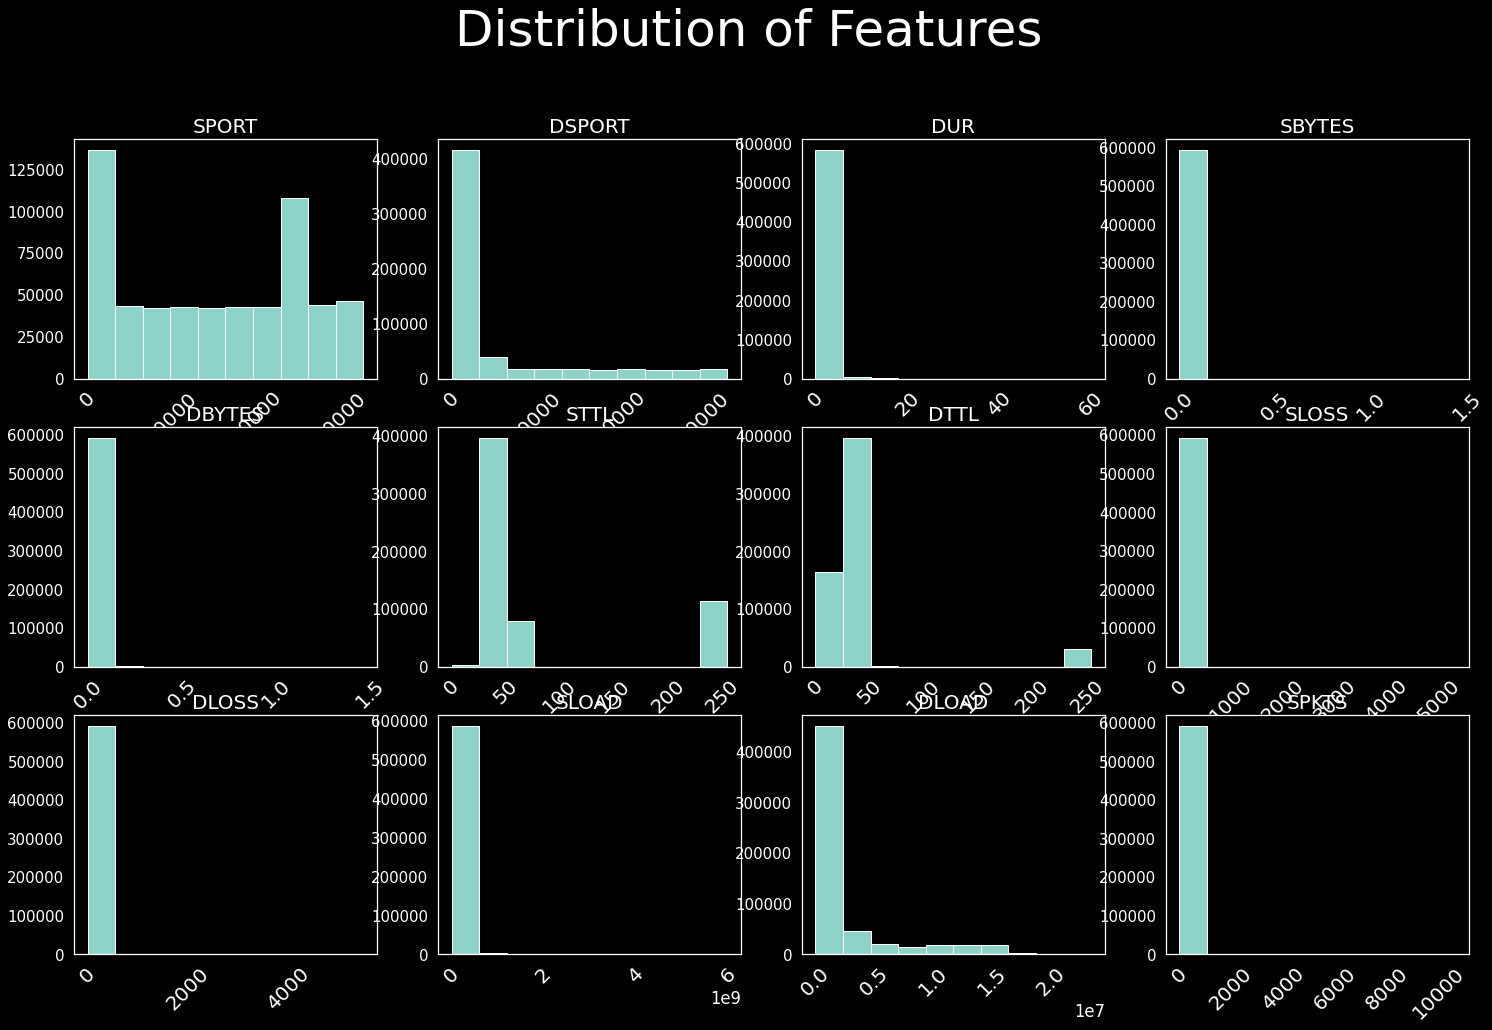

In [ ]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,41)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [ ]:
categorical_features = [item[0] for item in df.dtypes if item[1].startswith('string')]
print(categorical_features)

['proto_trans', 'state', 'proto', 'attack_cat']


Binary classification


In [ ]:
#convert Categorical data into Numeric data using StringIndexer
SI_proto_trans = StringIndexer(inputCol="proto_trans", outputCol="proto_trans_index")
SI_state = StringIndexer(inputCol="state", outputCol="state_index")
SI_proto = StringIndexer(inputCol="proto", outputCol="proto_index")
SI_attack_cat = StringIndexer(inputCol="attack_cat", outputCol="attack_cat_index")

In [ ]:
pipe = Pipeline(stages = [SI_proto_trans,SI_state,SI_proto,SI_attack_cat])

In [ ]:
df = pipe.fit(df).transform(df)
df.show()

+-----------+-----+------------+------+------+----+----+-----+-----+--------+---------+-----------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+----------+----------+------------+------------+------------+------------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+-----------------+-----------+-----------+----------------+
|proto_trans|state|         dur|sbytes|dbytes|sttl|dttl|sloss|dloss|   proto|    Sload|      Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|      Sjit|      Djit|     Sintpkt|     Dintpkt|      tcprtt|      synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|proto_trans_index|state_index|proto_index|attack

In [ ]:
pd_data = df.toPandas()

In [ ]:
 corr = pd_data.corr(method="pearson").round(2)
 corr

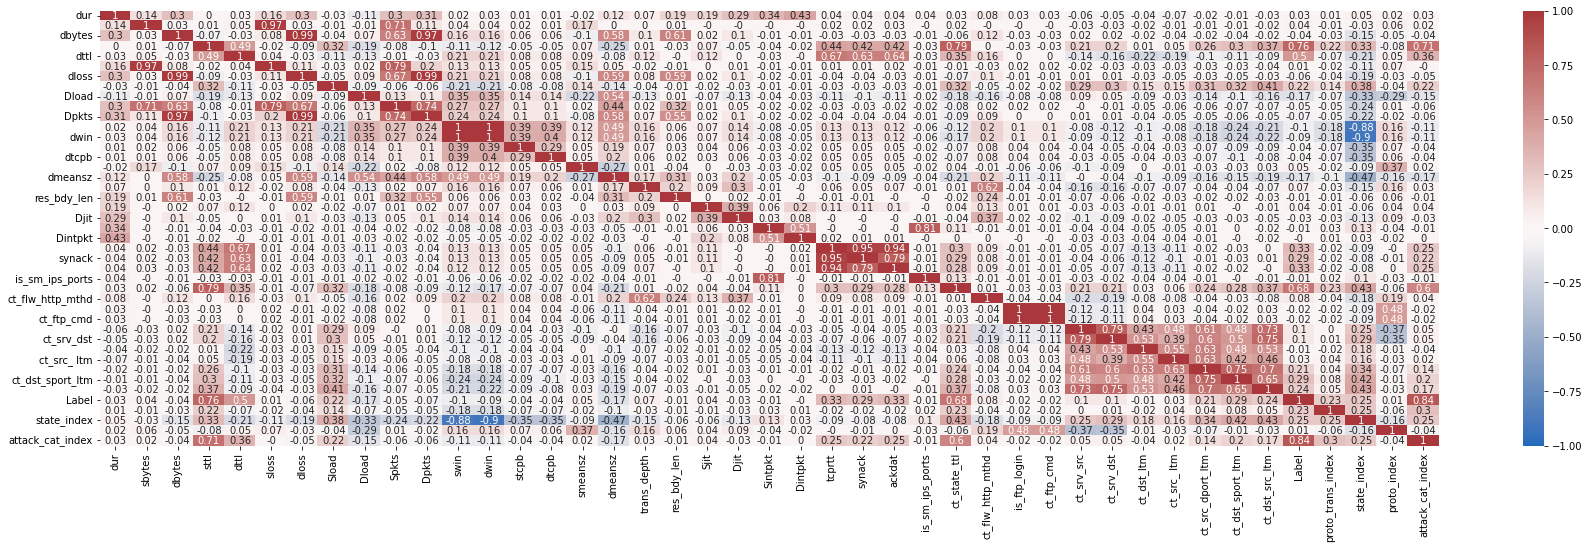

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (30,8))
sns.heatmap(corr,annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.savefig('heatmap.png')

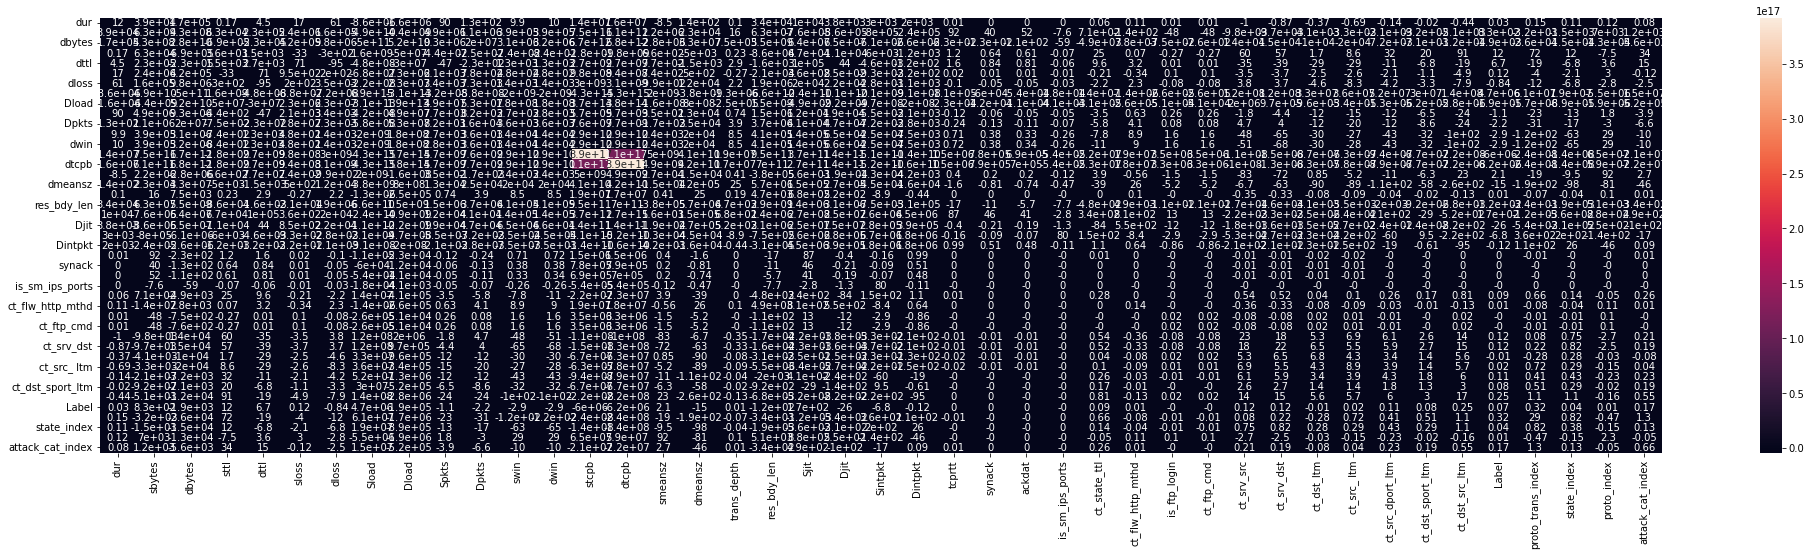

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (35,8))
sns.heatmap(covariance, annot=True)

In [ ]:
#create object and specify input and output column
OHE = OneHotEncoder(inputCols=['proto_trans_index','state_index', 'proto_index', 'attack_cat_index'], outputCols=['proto_trans_OHE','state_OHE','proto_OHE','attack_cat_OHE'])


In [ ]:
#transform the data
df = OHE.fit(df).transform(df)

In [ ]:
df.show()

+-----------+-----+------------+------+------+----+----+-----+-----+--------+---------+-----------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+----------+----------+------------+------------+------------+------------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+-----------------+-----------+-----------+----------------+---------------+--------------+--------------+--------------+
|proto_trans|state|         dur|sbytes|dbytes|sttl|dttl|sloss|dloss|   proto|    Sload|      Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|      Sjit|      Djit|     Sintpkt|     Dintpkt|      tcprtt|      synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|atta

In [ ]:
#creating feature vector for model to train
#drop colums
col = ['proto_trans','state','proto']
data_v = df.drop(*col)
data_v.show()


+------------+------+------+----+----+-----+-----+---------+-----------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+----------+----------+------------+------------+------------+------------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+-----------------+-----------+-----------+----------------+---------------+--------------+--------------+--------------+
|         dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|      Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|      Sjit|      Djit|     Sintpkt|     Dintpkt|      tcprtt|      synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|proto_trans_index|state_index|proto_index

In [ ]:
col = ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'Label', 'proto_trans_index', 'state_index', 'proto_index', 'attack_cat_index', 'proto_trans_OHE', 'state_OHE', 'proto_OHE', 'attack_cat_OHE']


In [ ]:
#col = data_v.columns
#print(col)
assembler = VectorAssembler(inputCols=col,outputCol='features')
data_v = assembler.transform(data_v)
data_n = data_v.select('features', 'Label').show() #we can apply truncate=False to see all features

+--------------------+-----+
|            features|Label|
+--------------------+-----+
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,5...|  0.0|
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,5...|  0.0|
|(210,[0,1,2,3,4,5...|  0.0|
|(210,[0,1,2,3,4,5...|  0.0|
|(210,[0,1,2,3,4,5...|  0.0|
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,5...|  0.0|
|(210,[0,1,2,3,4,5...|  0.0|
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,7...|  0.0|
|(210,[0,1,2,3,4,5...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
data_v.show()

+------------+------+------+----+----+-----+-----+---------+-----------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+----------+----------+------------+------------+------------+------------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+-----------------+-----------+-----------+----------------+---------------+--------------+--------------+--------------+--------------------+
|         dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|      Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|      Sjit|      Djit|     Sintpkt|     Dintpkt|      tcprtt|      synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|proto_trans_index|st

In [ ]:
print(data_v.columns)

['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label', 'proto_trans_index', 'state_index', 'proto_index', 'attack_cat_index', 'proto_trans_OHE', 'state_OHE', 'proto_OHE', 'attack_cat_OHE', 'features']


In [ ]:
columns = ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'Label', 'proto_trans_index', 'state_index', 'proto_index', 'attack_cat_index', 'proto_trans_OHE', 'state_OHE', 'proto_OHE', 'attack_cat_OHE', 'features']

Min Max Scaler
For scaling we are using MINMAX Method **bold text** **bold text**

In [ ]:
from pyspark.ml.feature import MinMaxScaler

In [ ]:
MinMaxScaler = MinMaxScaler(inputCol="features", outputCol="featuresScale")
final_data=MinMaxScaler.fit(data_v).transform(data_v)


In [ ]:
final_data.show()
#////////////////////////////////////////

+------------+------+------+----+----+-----+-----+---------+-----------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+----------+----------+------------+------------+------------+------------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+-----------------+-----------+-----------+----------------+---------------+--------------+--------------+--------------+--------------------+--------------------+
|         dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|      Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|      Sjit|      Djit|     Sintpkt|     Dintpkt|      tcprtt|      synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label

In [ ]:
#hypotesis testing for normal/attack
chi_test1 = ChiSquareTest.test(final_data, 'features', 'Label')

In [ ]:
chi_data1  = chi_test1.toPandas()

In [ ]:
chi_data1.transpose()

,0
pValues,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
degreesOfFreedom,"[196963, 5823, 5361, 12, 8, 285, 372, 288784, ..."
statistics,"[368277.1367758022, 372868.63346800895, 288643..."


In [ ]:
chi1 = chi_test1.head()
print("pValues: " + str(chi1.pValues))
print("degreesOfFreedom: " + str(chi1.degreesOfFreedom))
print("statistics: " + str(chi1.statistics))

pValues: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.185052470186747e-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034308183075140164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21744605655694238,0.0,0.0,0.0,0.0,0.5609731404077668,0.0,0.0,0.0,0.008610099952641725,5.3361929254314155e-05,0.1460778982284341,0.2945749319033081,0.3084836014780583,0.6146101594495135,0.6146101594495135,0.6146101594495135,0.6809928916406653,0.6809928916406653,0.0,0.002417

In [ ]:
train_data,test_data=final_data.randomSplit([0.80,0.20])

In [ ]:
train_data.show()
#//////////////////////////////////////////////

+---+------+------+----+----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+-----+-----------------+-----------+-----------+----------------+----------------+---------------+--------------+--------------+--------------------+--------------------+
|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|Sload|Dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|Label|proto_trans_index|state_index|proto_index|attack_cat_index| proto_trans_OHE|      state_OHE|     proto_OHE|attack_cat_OHE|            features|    

In [ ]:
# Create a logistic regression object for the model
logRegBinary =LogisticRegression(featuresCol='featuresScale', labelCol='Label', maxIter=120)

In [ ]:
# Undertake training and create a logistic regression model
lrModelBinary = logRegBinary.fit(train_data)

In [ ]:
summary = lrModelBinary.summary

In [ ]:
#Check accuracy of model
summary.accuracy

1.0

In [ ]:
#Using the Model make predictions on the test data 
lrBinary_pred=lrModelBinary.transform(test_data)
lrBinary_pred.show()

+------------+------+------+----+----+-----+-----+-----------+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+---------+----+------------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+---------------+-----+-----------------+-----------+-----------+----------------+----------------+--------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+----------+
|         dur|sbytes|dbytes|sttl|dttl|sloss|dloss|      Sload|Dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|Djit|     Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|     attack_cat|Label|proto_trans_i

In [ ]:
lr_pred.select('featuresScale','rawPrediction','Label', 'prediction', 'probability').toPandas().head(5)

,featuresScale,rawPrediction,Label,prediction,probability
0,"(0.0, 1.9504347170692433e-06, 0.0, 0.996078431...","[31.772649045808603, -31.772649045808603]",0.0,0.0,"[0.999999999999984, 1.5896951306344786e-14]"
1,"(0.0, 1.9504347170692433e-06, 3.13831845213221...","[24.02709396835414, -24.02709396835414]",0.0,0.0,"[0.9999999999632578, 3.6742243697668275e-11]"
2,"(0.0, 3.204285606613757e-06, 0.0, 0.0, 0.0, 0....","[19.482619308489877, -19.482619308489877]",0.0,0.0,"[0.9999999965421518, 3.4578483276229474e-09]"
3,"(0.0, 3.204285606613757e-06, 0.0, 0.0, 0.0, 0....","[23.13057572560234, -23.13057572560234]",0.0,0.0,"[0.9999999999099427, 9.005723298167497e-11]"
4,"(0.0, 3.204285606613757e-06, 0.0, 0.0, 0.0, 0....","[23.13057572560234, -23.13057572560234]",0.0,0.0,"[0.9999999999099427, 9.005723298167497e-11]"


In [ ]:
lrBinary_accuracy=MulticlassClassificationEvaluator(labelCol='Label',metricName='accuracy').evaluate(lr_pred)
print('The Model Accuracy is',lrBinary_accuracy)

The Model Accuracy is 1.0


In [ ]:
actual_Binary = lrBinary_pred.select('Label').toPandas()
pred_Binary = lrBinary_pred.select('prediction').toPandas()

In [ ]:
def plot_confusion_matrix(data, labels, output_filename):
    sns.set(color_codes=True)
    plt.figure(1, figsize=(30,9))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1.5)
    ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", cbar_kws={'label': 'Scale'}, fmt='.2%')
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

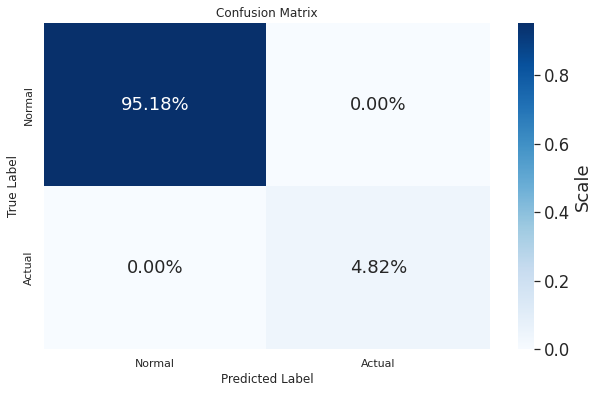

In [ ]:
labels_Binary = ['Normal','Actual']
cnmatrix_Binary = confusion_matrix(actual_Binary, pred_Binary)
plot_confusion_matrix(cnmatrix_Binary, labels_Binary, "confusion_matrix.png")


In [ ]:
print(classification_report(actual_Binary,pred_Binary,target_names=['Normal','Attack']))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    392319
      Attack       1.00      1.00      1.00     19859

    accuracy                           1.00    412178
   macro avg       1.00      1.00      1.00    412178
weighted avg       1.00      1.00      1.00    412178



Multi CLassification

In [ ]:
final_data.show()

+------------+------+------+----+----+-----+-----+---------+-----------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+----------+----------+------------+------------+------------+------------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+-----------------+-----------+-----------+----------------+---------------+--------------+--------------+--------------+--------------------+--------------------+
|         dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|      Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|      Sjit|      Djit|     Sintpkt|     Dintpkt|      tcprtt|      synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label

In [ ]:
final_data.printSchema()

In [ ]:
multiData = final_data.select('featuresScale', 'attack_cat_index')

In [ ]:
multiData.printSchema()

root
 |-- featuresScale: vector (nullable = true)
 |-- attack_cat_index: double (nullable = false)



In [ ]:
multiData.show(500)

In [ ]:
class_temp = final_data.select("attack_cat").groupBy("attack_cat")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["attack_cat"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
multi_labels = class_temp

In [ ]:
data_multi = multiData.withColumnRenamed("featuresScale","features")
data_multi = data_multi.withColumnRenamed("attack_cat_index","Label")

In [ ]:
data_multi.select('Label').distinct().show(500)

+-----+
|Label|
+-----+
|  8.0|
|  0.0|
|  7.0|
|  1.0|
|  4.0|
|  3.0|
|  2.0|
|  6.0|
|  5.0|
|  9.0|
+-----+



In [ ]:
data_multi.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Label: double (nullable = false)



In [ ]:
traindata,testdata=data_multi.randomSplit([0.80,0.20])

In [ ]:
#from pyspark.ml.classification import OneVsRest

lr_multi=LogisticRegression(featuresCol='features', labelCol='Label',family="multinomial")


In [ ]:
lr_multi_model = lr_multi.fit(traindata)

In [ ]:
lr_multi_pred=lr_multi_model.transform(testdata)
lr_multi_pred.show(500)

In [ ]:
lr_multi_accuracy=MulticlassClassificationEvaluator(labelCol='Label',metricName='accuracy').evaluate(lr_multi_pred)
print('The Model Accuracy is',lr_multi_accuracy)

The Model Accuracy is 1.0


In [ ]:
lr_multi_pred.select('features','rawPrediction','Label', 'prediction', 'probability').show()

+--------------------+--------------------+-----+----------+--------------------+
|            features|       rawPrediction|Label|prediction|         probability|
+--------------------+--------------------+-----+----------+--------------------+
|(210,[0,1,2,3,4,5...|[24.5679667728401...|  0.0|       0.0|[0.99999999996298...|
|(210,[0,1,2,3,4,5...|[22.5260915817969...|  0.0|       0.0|[0.99999999952861...|
|(210,[0,1,2,3,4,5...|[21.7396822950017...|  0.0|       0.0|[0.99999999949004...|
|(210,[0,1,2,3,4,5...|[21.6604634273797...|  0.0|       0.0|[0.99999999944683...|
|(210,[0,1,2,3,4,5...|[23.0368130662213...|  0.0|       0.0|[0.99999999976576...|
|(210,[0,1,2,3,4,5...|[21.2030747063951...|  0.0|       0.0|[0.99999999905357...|
|(210,[0,1,2,3,4,5...|[21.9680774708259...|  0.0|       0.0|[0.99999999960704...|
|(210,[0,1,2,3,4,5...|[22.0135851721829...|  0.0|       0.0|[0.99999999962811...|
|(210,[0,1,2,3,4,5...|[21.2121262742873...|  0.0|       0.0|[0.99999999911657...|
|(210,[0,1,2,3,4

In [ ]:
y_true = list(final_data.select('attack_cat').distinct().toPandas()['attack_cat'])

In [ ]:
actual_multi_pred = lr_multi_pred.select('Label').toPandas()
pred_multi_pred = lr_multi_pred.select('prediction').toPandas()

In [ ]:
actual_multi = lr_multi_pred.select('Label').distinct().toPandas()
pred_multi = lr_multi_pred.select('prediction').distinct().toPandas()

In [ ]:
cnmatrix_final = confusion_matrix(actual_multi, pred_multi)

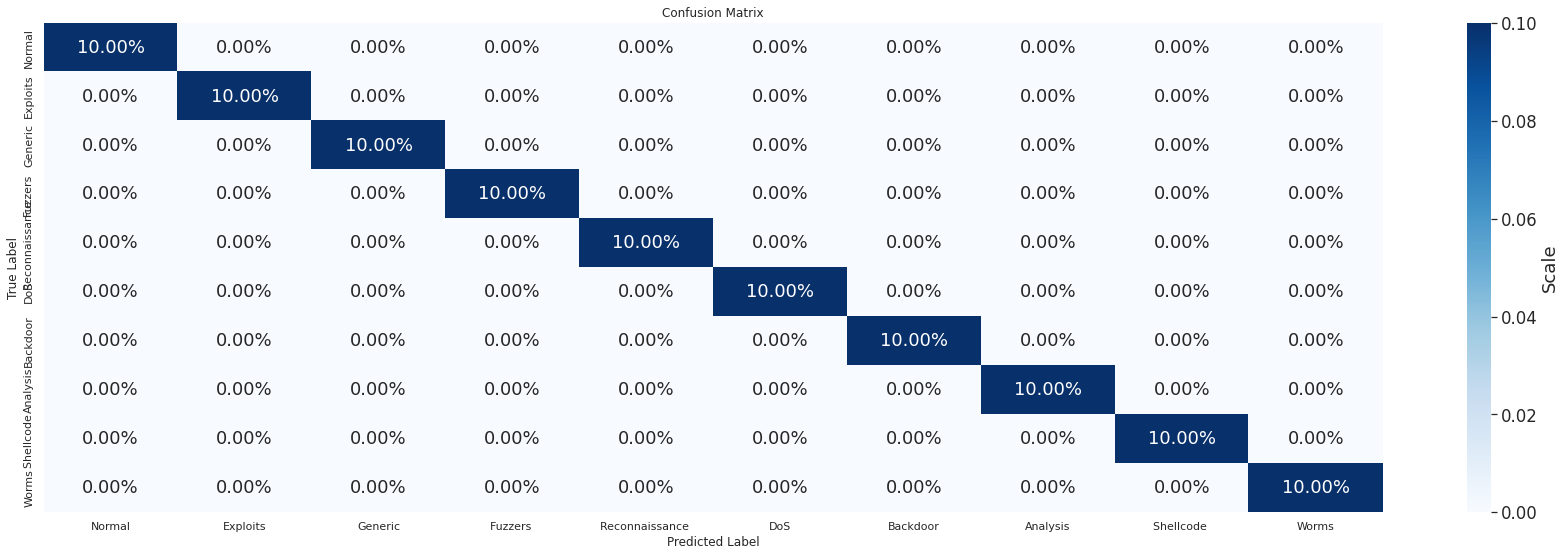

In [ ]:
plot_confusion_matrix(cnmatrix_final, multi_labels, 'test.png')

In [ ]:
print(classification_report(actual_multi_pred,pred_multi_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    137577
         1.0       1.00      1.00      1.00      3308
         2.0       1.00      1.00      1.00      3008
         3.0       1.00      1.00      1.00      2457
         4.0       1.00      1.00      1.00      1612
         5.0       1.00      1.00      1.00       645
         6.0       1.00      1.00      1.00       231
         7.0       1.00      1.00      1.00       243
         8.0       1.00      1.00      1.00       172
         9.0       1.00      1.00      1.00        13

    accuracy                           1.00    149266
   macro avg       1.00      1.00      1.00    149266
weighted avg       1.00      1.00      1.00    149266

